In [1]:
# load dependencies'
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' surpresses warnings at spatial distribution
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import numpy as np
import datetime
import plotly.express as px
import plotly.graph_objects as go

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# pandas show all columns of table instead of restricted#
pd.set_option('display.max_columns', None)

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))


In [2]:
bbox = BboxSelector([
    7.554130554199218, # min_x
    51.95590322041212, # min_y
    7.590351104736328, # max_x
    51.97874790276371  # max_y
])

# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=20) 
track_df = track_df.select_dtypes(['float64'])

In [57]:
# Correlation coeffefficients strength
#.00-.39  weak
#.40-.59  moderate
#.60-.79  strong
#.80-1.0  very strong

def get_classified_correlations(df, method):
    allCoeffs=[]
    correlationsMatrixAll = df.corr(method=method)
    for column in correlationsMatrixAll:
        for i in correlationsMatrixAll[column].index:
            df = correlationsMatrixAll.at[i, column]
            if df != 1.0:
                allCoeffs.append({'column':column, 'index':i, 'coefficient':df })
 
    correlationsMatrix = correlationsMatrixAll.where(np.tril(np.ones(correlationsMatrixAll.shape)).astype(np.bool))
    
    very_strong=[]
    strong=[]
    moderate=[]
    weak=[]   
    for column in correlationsMatrix:
        for i in correlationsMatrix[column].index:
            df = correlationsMatrix.at[i, column]
            if df >= 0.8 and df < 1.0 or df <= -0.8 and df > -1.0:
                very_strong.append({'column':column, 'index':i, 'coefficient':df })#   
            if df >= 0.6 and df < 0.8 or df <= -0.6 and df > -0.8:
                strong.append({'column':column, 'index':i, 'coefficient':df })
            if df >= 0.4 and df < 0.6 or df <= -0.4 and df > -0.6:
                moderate.append({'column':column, 'index':i, 'coefficient':df })
            if df < 0.4 and df > -0.4:
                weak.append({'column':column, 'index':i, 'coefficient':df })
    
    very_strong = pd.DataFrame(very_strong).sort_values(by='coefficient', ascending=False).reset_index(drop=True)
    strong = pd.DataFrame(strong).sort_values(by='coefficient', ascending=False).reset_index(drop=True)
    moderate = pd.DataFrame(moderate).sort_values(by='coefficient', ascending=False).reset_index(drop=True)
    weak=pd.DataFrame(weak).sort_values(by='coefficient', ascending=False).reset_index(drop=True)
    allCoeffs= pd.DataFrame(allCoeffs).sort_values(by='coefficient', ascending=False).reset_index(drop=True)

    return allCoeffs, very_strong, strong, moderate, weak 



def correlation_heatmap_triangle(df, method, figsize=(20, 16)):
    coefficient = df.corr(method=method)
    coefficient = coefficient.where(np.tril(np.ones(coefficient.shape)).astype(np.bool))
    plt.figure(figsize=figsize)
    sns.heatmap(coefficient, annot = True, vmin=-1, vmax=1.0, cmap="RdBu_r")

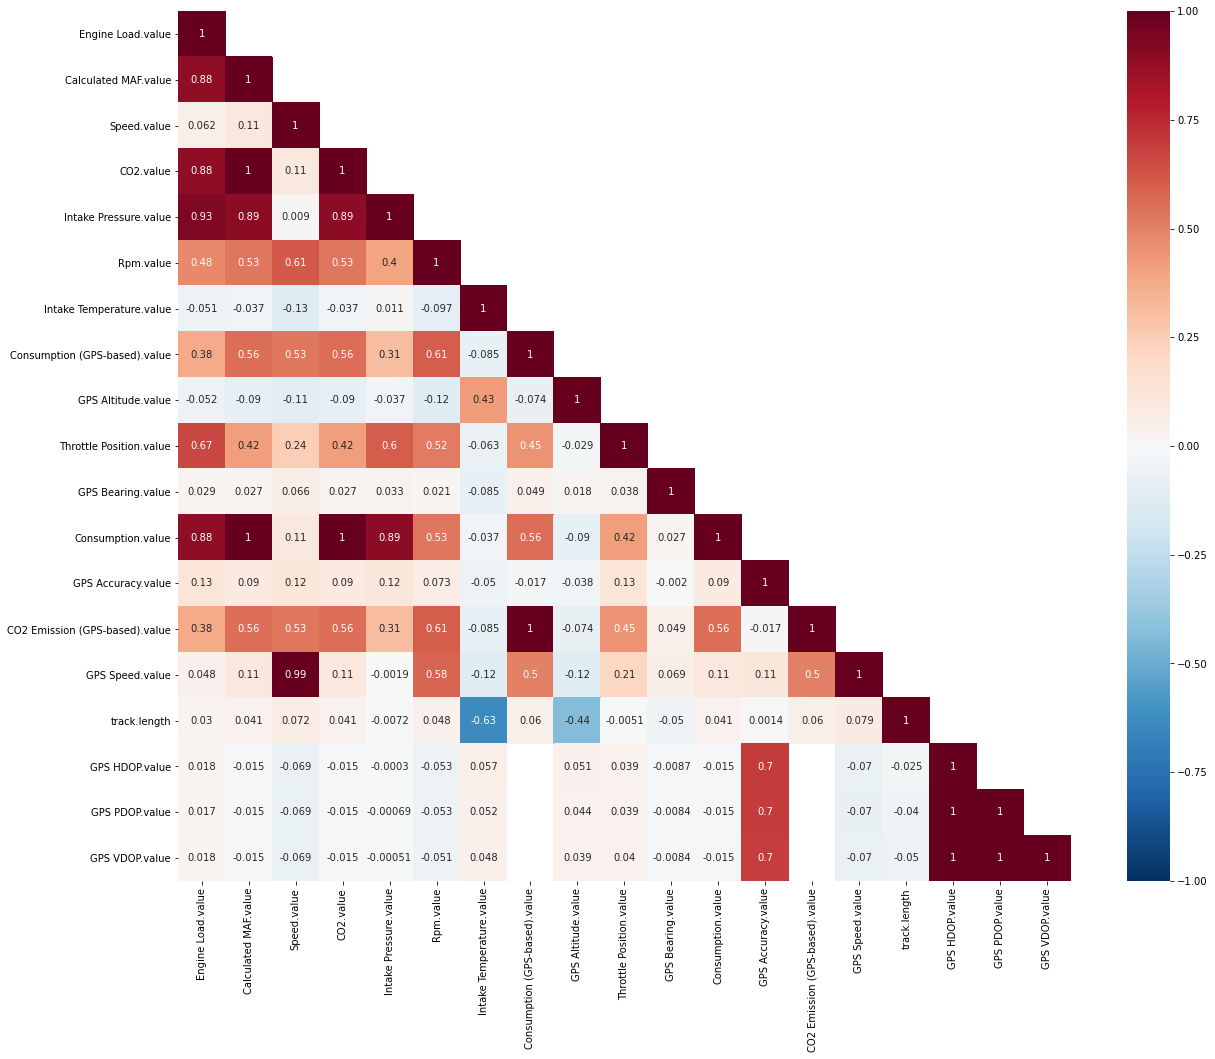

In [47]:
# Person correlation matrix
correlation_heatmap_triangle(track_df, 'pearson')

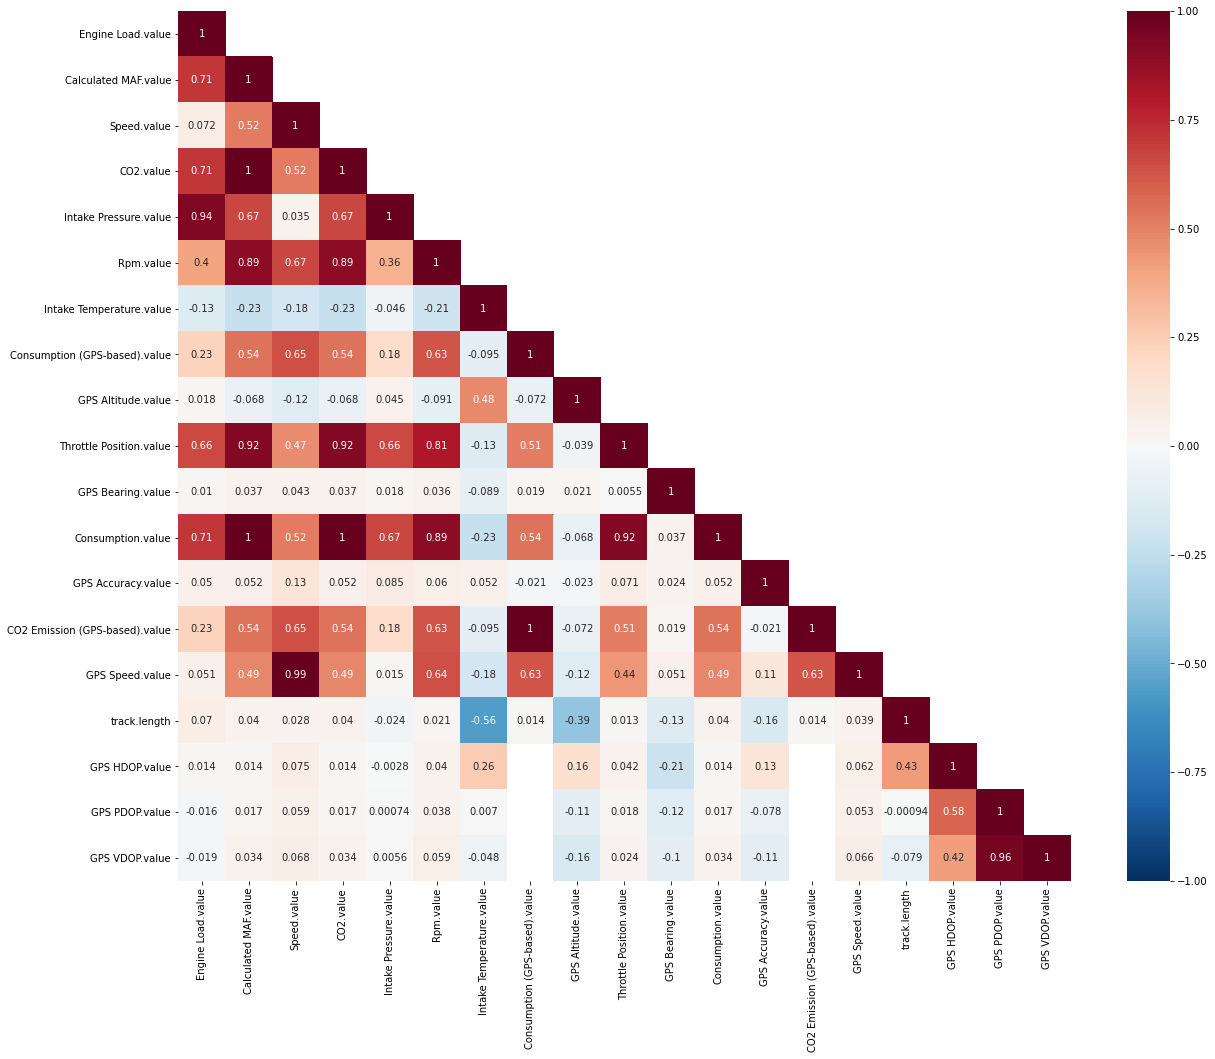

In [48]:
# Spearman Rho
#The intuition for the Spearman’s rank correlation is that it calculates a Pearson’s correlation 
#(i.e. a parametric measure of correlation) using the rank values instead of the real values. 
correlation_heatmap_triangle(track_df, 'spearman')

In [58]:
# classify correlations according to their strengths
allCoeffs, very_strong, strong, moderate, weak  = get_classified_correlations(track_df, 'spearman')

In [59]:
# if we are interested in a relationship between certain two variables:
allCoeffs.loc[(allCoeffs['column'] == 'Intake Pressure.value') & (allCoeffs['index'] == 'Engine Load.value')]

,column,index,coefficient
5,Intake Pressure.value,Engine Load.value,0.935741


In [60]:
# we are interested in very strong correlational relationships (coefficient > 0.8)
very_strong

,column,index,coefficient
0,Speed.value,GPS Speed.value,0.993835
1,GPS PDOP.value,GPS VDOP.value,0.955225
2,Engine Load.value,Intake Pressure.value,0.935741
3,Calculated MAF.value,Throttle Position.value,0.917590
4,CO2.value,Throttle Position.value,0.917590
5,Throttle Position.value,Consumption.value,0.917590
6,Calculated MAF.value,Rpm.value,0.891476
7,CO2.value,Rpm.value,0.891476
8,Rpm.value,Consumption.value,0.891476
9,Rpm.value,Throttle Position.value,0.807050
